# Experiments with FactorVAE
## Load Data and Model

In [36]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob

device = 'cpu'
dataset = np.load("dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz")
imgs = dataset['imgs']  # (737280, 64, 64)
num_imgs = imgs.shape[0]

# (need to define the model here again because model saving in google colab has some problems)
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class FactorVAE(nn.Module):
    def __init__(self):
        super().__init__()

        # padding=1 so that dimension gets cut in half exactly
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            View((-1, 64*4*4)),
            nn.Linear(64*4*4, 128),  # no relu here?
            nn.Linear(128, 20),
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 64*4*4),
            nn.ReLU(),
            View((-1, 64, 4, 4)),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        t = self.encoder(x)
        mu = t[..., :10]
        log_sigma2 = t[..., 10:]
        sigma = torch.exp(1/2 * log_sigma2)  # output is log variance
        epsilon = torch.randn_like(mu)  # mean 0 std 1 shaped like mu
        z = mu + sigma * epsilon
        x_tilde = self.decoder(z)

        return x_tilde, z, mu, log_sigma2
    

vae_model = torch.load(glob.glob("models/vae30_it95000_recon*.pt")[0], map_location=torch.device('cpu'))

## Reconstruction
Recreating first two rows of Figure 6

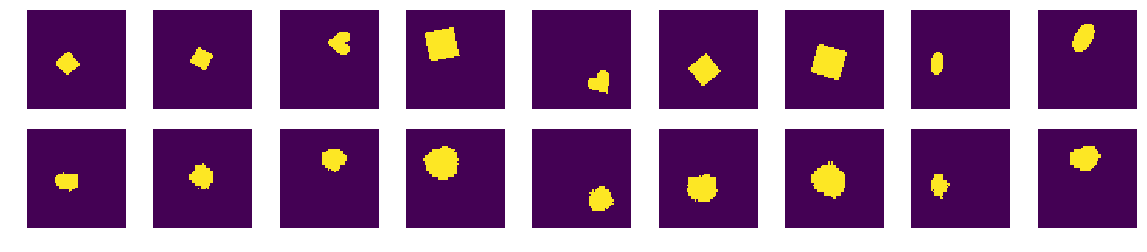

In [39]:
plt.figure(figsize=(20, 4))
for i in range(9):
    img = imgs[np.random.randint(num_imgs)]
    plt.subplot(2, 9, 1+i)
    plt.axis('off')
    plt.imshow(img)

    x = torch.tensor(img[np.newaxis, np.newaxis, :, :]).float().to(device)
    x_recon, z, _, _ = vae_model(x)
    img_recon = np.exp(x_recon.detach().cpu().numpy().squeeze())
    
    # exponentiate logits and threshold to binary 0 1 
    img_recon = np.heaviside(img_recon-0.5, 1)
    plt.subplot(2, 9, 10+i)
    plt.axis('off')
    plt.imshow(img_recon)
    
    

Top row: originals.  
Bottom row: reconstructions

## Latent Traversals
Remaining rows of Figure 6. I am not sorting the latent dimensions by KL divergence, but simply displaying all 10 latent dimensions.

tensor([[ -89.4754, -223.6071,  185.0680,    7.6916,  173.8219,   83.2910,
          -27.5270,  158.8076, -127.4100, -182.2045]], grad_fn=<AddBackward0>)


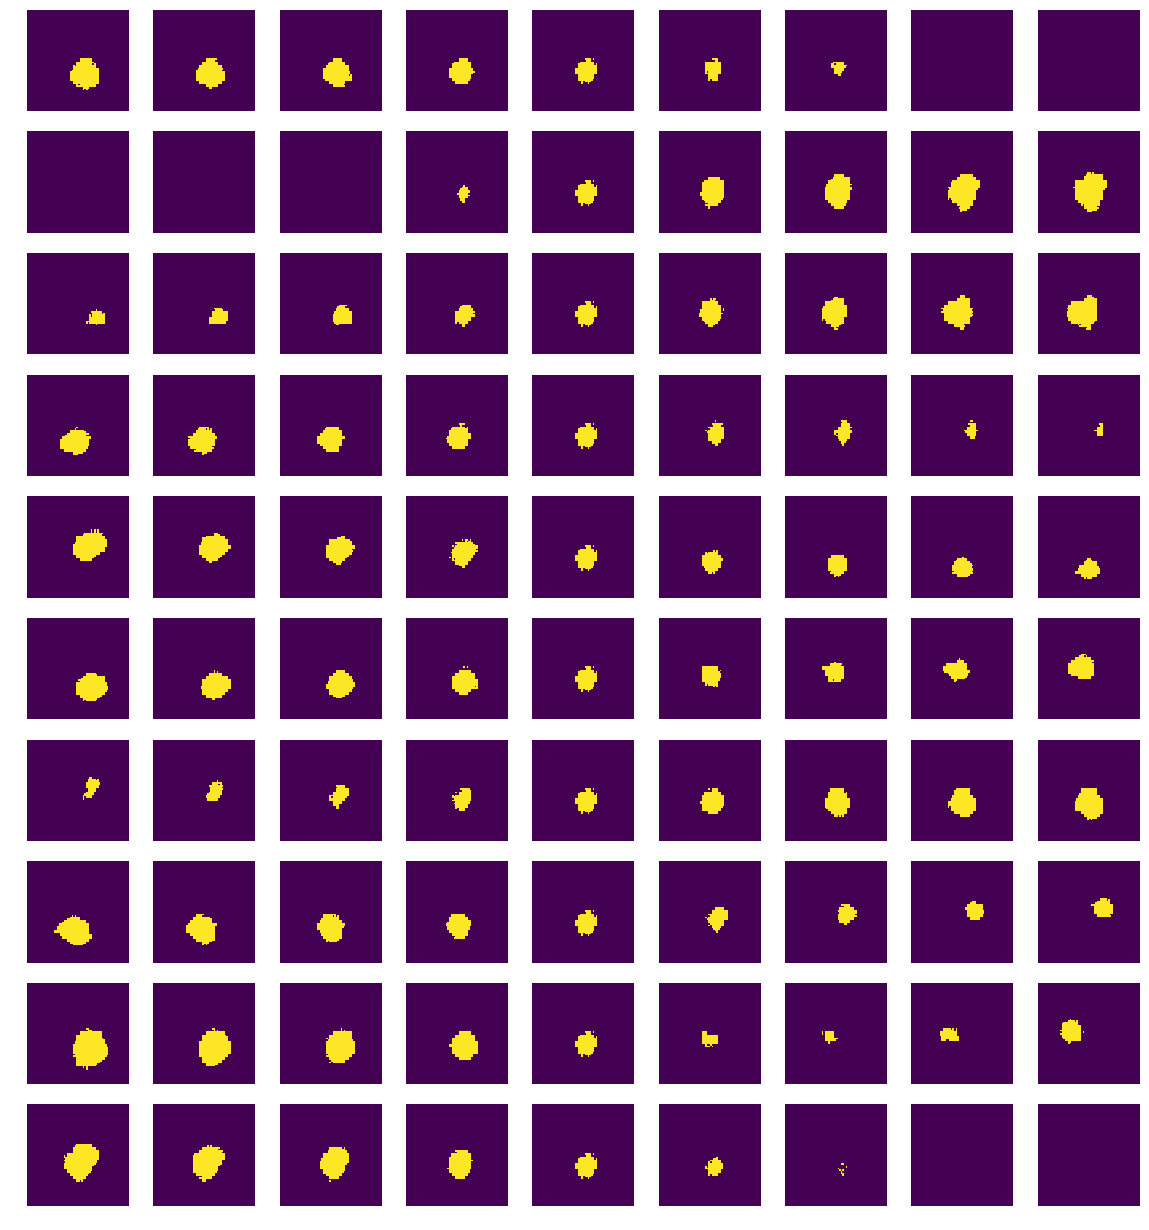

In [55]:
img = imgs[np.random.randint(num_imgs)]
x = torch.tensor(img[np.newaxis, np.newaxis, :, :]).float().to(device)

_, z, _, _ = vae_model(x)
print(z)
plt.figure(figsize=(20, 22))
for latent_idx in range(10):
    for i in range(9):
        plt.subplot(10, 9, latent_idx*9+1+i)
        plt.axis('off')
        z_alt = z.clone()
        z_alt[0, latent_idx] += 5*(0.5*i-2)  # from -2 to 2 in 0.5 increments
        x_recon = vae_model.decoder(z_alt)
        img_recon = np.exp(x_recon.detach().cpu().numpy().squeeze())
        img_recon = np.heaviside(img_recon-0.5, 1)
        plt.imshow(img_recon)